In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import numpy as np
import matplotlib.pyplot as plt
fig_width = 12
%matplotlib inline

# OBSOLETE

# the switching binomial generative model
## the data to model

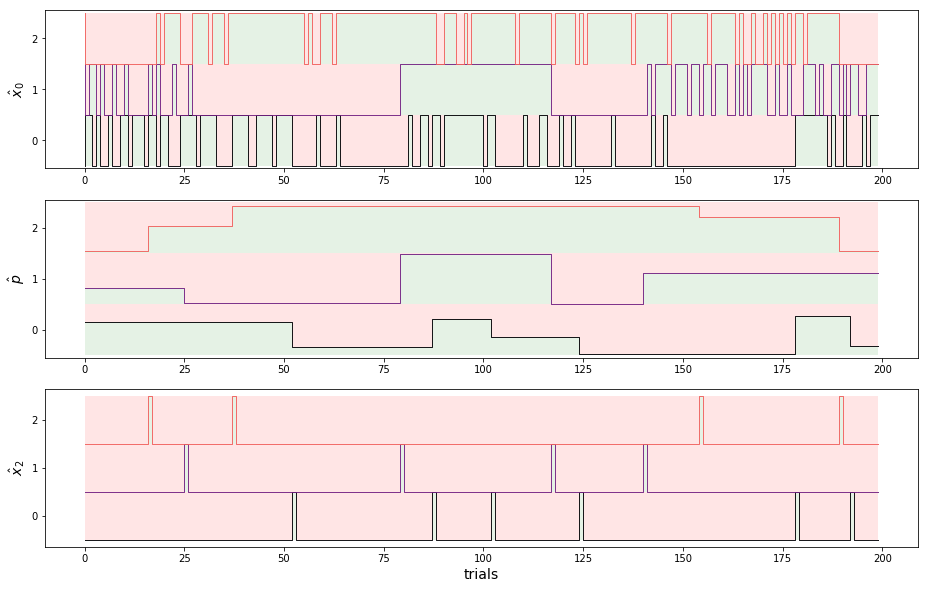

In [2]:
import sys
sys.path.append('..')

from aSPEM import binomial_motion, aSPEM

import time
a = aSPEM(mode='model', timeStr = time.strftime("%Y-%m-%d_%H%M%S", time.localtime()))

fig, axs, p = a.plot()

In [3]:
p.shape

(200, 3, 3)

In [4]:
i_block = 0
print('occurrences=', p[:, i_block, 0])
print('p=', p[:, i_block, 1])
print('switches=', p[:, i_block, -1])

occurrences= [ 0.  1.  1.  0.  1.  0.  0.  1.  0.  0.  1.  1.  0.  1.  1.  1.  0.  1.
  1.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  0.
  0.  0.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.
  1.  1.]
p= [ 0.64752352  0.64752352  0.64752352  0.64752352  0.64752352  0.64752352
  0.64752352  0.64752352  0.64752352  0.64752352  0.64752352  0.64752352
  0.64752352  0.64752352 

In [5]:
N_trials = a.exp['N_trials']
h = 1./a.exp['tau']
print('this experiment uses', N_trials, 'trials and a switch rate of h=', h, '(that is, one switch every', 1/h, 'trials on average)')

this experiment uses 200 trials and a switch rate of h= 0.025 (that is, one switch every 40.0 trials on average)


In [6]:
def likelihood_beta(o, p, r):
    """
    for the beta-binomial probability of length 1, the likelihood of drawing o in {0, 1}
    is equal to 
        
    """
    from scipy.stats import beta as sp_beta
    from scipy.special import gamma

    new_p = (p*r + o) / (r+1)
    alpha, beta = p*r, (1-p)*r
    beta_pdf = gamma(alpha+beta)/gamma(alpha)/gamma(beta) * new_p**alpha * (1-new_p)**beta
    #print (p, r, o, new_p, sp_beta.pdf(new_p, p*r, (1-p)*r), beta_pdf)
    L = np.array(beta_pdf)
    L[p==0] = 1-o
    L[p==1] = o
    L[r==0] = .5 
    return L

def likelihood_heur(o, p, r):
    """
    for the beta-binomial probability of length 1, the likelihood of drawing o in {0, 1}
    is equal to 
        
    """
    #return o/(1+(1-p)*r) + (1-o) / (1 + p*r) 
    return ((p*r + o) + ((1-p) + (1-o)/ (r+1))) 

def likelihood(o, p, r, Z=None):
    """
    Un-normalized function
    for the beta-binomial probability of length 1, the likelihood of drawing o in {0, 1}
    is equal to 
        
    """
    if Z is None:
        Z = likelihood(0, p, r, Z=1) + likelihood(1, p, r, Z=1)
    return Z**-1 * likelihood_heur(o, p, r)

def likelihood_heur2(o, p, r):
    """
    for the beta-binomial probability of length 1, the likelihood of drawing o in {0, 1}
    is equal to 
        
    """
    return 1/(r+2) * ((1-o) * (1+(1-p)*r) + o* (1 + p*r))
    #return .5 * (r==0) + ((1-o) * (1-p) + o * p) * (r>0)
    #return r / (r+1) * ((1-o) * (1-p) + o * p) 

for likelihood__ in [likelihood, likelihood_heur]:
    help(likelihood__)
    for p_ in [.25, .5, .75]:
        for r in (2**np.arange(5)-1):
            print('Knowing p=', p_, 'and r=', r, ', the likelihood for 0=', likelihood__(0, p_, r), ', for 1=', likelihood__(1, p_, r), ', sum=', likelihood__(0, p_, r)+likelihood__(1, p_, r))

Help on function likelihood in module __main__:

likelihood(o, p, r, Z=None)
    Un-normalized function
    for the beta-binomial probability of length 1, the likelihood of drawing o in {0, 1}
    is equal to

Knowing p= 0.25 and r= 0 , the likelihood for 0= 0.5 , for 1= 0.5 , sum= 1.0
Knowing p= 0.25 and r= 1 , the likelihood for 0= 0.428571428571 , for 1= 0.571428571429 , sum= 1.0
Knowing p= 0.25 and r= 3 , the likelihood for 0= 0.411764705882 , for 1= 0.588235294118 , sum= 1.0
Knowing p= 0.25 and r= 7 , the likelihood for 0= 0.428571428571 , for 1= 0.571428571429 , sum= 1.0
Knowing p= 0.25 and r= 15 , the likelihood for 0= 0.453416149068 , for 1= 0.546583850932 , sum= 1.0
Knowing p= 0.5 and r= 0 , the likelihood for 0= 0.5 , for 1= 0.5 , sum= 1.0
Knowing p= 0.5 and r= 1 , the likelihood for 0= 0.428571428571 , for 1= 0.571428571429 , sum= 1.0
Knowing p= 0.5 and r= 3 , the likelihood for 0= 0.428571428571 , for 1= 0.571428571429 , sum= 1.0
Knowing p= 0.5 and r= 7 , the likelihood for

In [7]:
np.arange(0, 1+1)

array([0, 1])

In [8]:
from scipy.stats import beta
help(beta.ppf)
beta.ppf([.25, .75], a=14., b=14.)

Help on method ppf in module scipy.stats._distn_infrastructure:

ppf(q, *args, **kwds) method of scipy.stats._continuous_distns.beta_gen instance
    Percent point function (inverse of `cdf`) at q of the given RV.
    
    Parameters
    ----------
    q : array_like
        lower tail probability
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information)
    loc : array_like, optional
        location parameter (default=0)
    scale : array_like, optional
        scale parameter (default=1)
    
    Returns
    -------
    x : array_like
        quantile corresponding to the lower tail probability q.



array([ 0.43596102,  0.56403898])

## performing inference: application to synthetic data

time 0 ; obs= 0 ; beliefs= [ 1.] ; p_hat= [ 0.5] ; 1-h= 0.995 ; p_bar= [ 0.5]
Note that at t 0 , belief 0.005 = h =  0.005
time 1 ; obs= 0 ; beliefs= [ 0.005  0.995] ; p_hat= [ 0.5         0.42857143] ; 1-h= 0.995 ; p_bar= [ 0.5  0. ]
Note that at t 1 , belief 0.005 = h =  0.005
time 2 ; obs= 0 ; beliefs= [ 0.005       0.00579933  0.98920067] ; p_hat= [ 0.5         0.42857143  0.4       ] ; 1-h= 0.995 ; p_bar= [ 0.5  0.   0. ]
Note that at t 2 , belief 0.005 = h =  0.005
time 3 ; obs= 0 ; beliefs= [ 0.005       0.00620842  0.00617223  0.98261935] ; p_hat= [ 0.5         0.42857143  0.4         0.38461538] ; 1-h= 0.995 ; p_bar= [ 0.5  0.   0.   0. ]
Note that at t 3 , belief 0.005 = h =  0.005
time 4 ; obs= 1 ; beliefs= [ 0.005       0.00645165  0.00686649  0.00637137  0.97531048] ; p_hat= [ 0.5         0.57142857  0.6         0.61538462  0.625     ] ; 1-h= 0.995 ; p_bar= [ 0.5  0.   0.   0.   0. ]
Note that at t 4 , belief 0.005 = h =  0.005
time 5 ; obs= 1 ; beliefs= [ 0.005       0.00

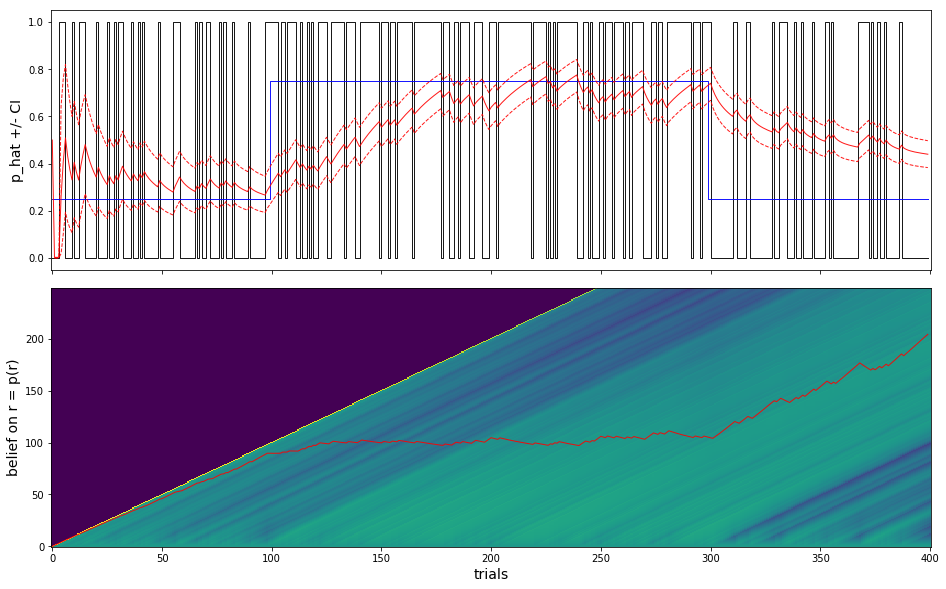

In [9]:
# -*- coding: utf8 -*-
"""
 An implementation of:
 @TECHREPORT{ adams-mackay-2007,
    AUTHOR = {Ryan Prescott Adams and David J.C. MacKay},
    TITLE  = "{B}ayesian Online Changepoint Detection",
    INSTITUTION = "University of Cambridge",
    ADDRESS = "Cambridge, UK",
    YEAR = "2007",
    NOTE = "arXiv:0710.3742v1 [stat.ML]"
 }
 
 adapted from
    url='https://github.com/laurentperrinet/bayesianchangepoint',
    
 by
    Copyright 2013 Jack Kelly (aka Daniel) jack@jack-kelly.com
    author='Jack Kelly',
    author_email='jack@jack-kelly.com',

which is adapted from the matlab code @

    http://hips.seas.harvard.edu/content/bayesian-online-changepoint-detection
    

"""
from __future__ import print_function, division
import numpy as np
from numpy.random import gamma, randn, rand
from scipy.special import gammaln

def plot_inference(self, o, p_true, p_bar, r, beliefs, mode=None, fig=None, axs=None, fig_width=13, max_run_length=120):
    N_trials = o.size #self.exp['N_trials']
    p_hat = np.sum(p_bar[:, 1:] * beliefs[:, :-1], axis=0)
    r_hat = np.sum(r * beliefs, axis=0)

    if fig is None:
        fig_width= fig_width
        fig, axs = plt.subplots(2, 1, figsize=(fig_width, fig_width/1.6180), sharex=True)
    axs[0].step(range(N_trials), o, lw=1, alpha=.9, c='k')
    axs[0].step(range(N_trials), p_true, lw=1, alpha=.9, c='b')
    from scipy.stats import beta
    p_low, p_sup = np.zeros_like(p_hat), np.zeros_like(p_hat)
    for i_trial in range(N_trials):
        p_low[i_trial], p_sup[i_trial] = beta.ppf([.05, .95], a=p_hat[i_trial]*r_hat[i_trial], b=(1-p_hat[i_trial])*r_hat[i_trial])
    
    axs[0].plot(range(N_trials), p_hat, lw=1, alpha=.9, c='r')
    axs[0].plot(range(N_trials), p_sup, 'r--', lw=1, alpha=.9)
    axs[0].plot(range(N_trials), p_low, 'r--', lw=1, alpha=.9)
    axs[1].imshow(np.log(beliefs[:max_run_length, :] + 1.e-5 ))
    axs[1].plot(range(N_trials), r_hat[:-1], lw=1, alpha=.9, c='r')

    fig.tight_layout()
    for i_layer, label in zip(range(2), ['p_hat +/- CI', 'belief on r = p(r)']): 
        axs[i_layer].set_xlim(0, N_trials)
        axs[i_layer].set_ylim(-.05, 1 + .05)
        axs[i_layer].axis('tight')
#            axs[i_layer].set_yticks(np.arange(1)+.5)
#            axs[i_layer].set_yticklabels(np.arange(1) )
        axs[i_layer].set_ylabel(label, fontsize=14)
        axs[i_layer].axis('tight')
    axs[-1].set_xlabel('trials', fontsize=14);

    return fig, axs

def inference(o, h=h, p0=.5, verbose=True):
    """
    Args:
      * o (np.ndarray): data has given in a sequence of observations as a 
        function of (dicscrete) time (or trials). The totla number of trials
        is T.
      
      * h (float): hazard rate, a value in the interval [0,1] that is the 
        probability of a changepoint at any given time.

      * p0, r0 (float, float): specify initial values for beta-distribution.
      
      * alpha0, beta0 (float, float): specify prior beta-distribution for p.
        This data is Binomial with unknown mean.  We are going to
        use the standard conjugate prior of a beta-ditribution. ** Note that
        one cannot use non-informative priors for changepoint detection in
        this construction.  The beta-ditribution yields a closed-form
        predictive distribution, which makes it easy to use in this context. **
        
    Output:
      * beliefs (np.ndarray): beliefs about the current run lengths, the first 
          axis (one row) is the probability vector at any given time. This vector
          is of length at maximum T( the maximal run length). It represents the
          probability of a given run-length after one observation.
          
      * p_bar (np.ndarray): mean of the prediction about p. Given the run-lengths r,
          this gives the sufficient statistics for our belief about p at any given 
          time.

            - the first axis records the estimated prebabilities
            for the different hypothesis of run lengths
            - the second axis is time (trials) - the system has only access to the present
            time, but this is a convenience for plots.

    """
    T = o.size # total number of observations
    # First, setup the matrix that will hold our beliefs about the current
    # run lengths.  We'll initialize it all to zero at first.  
    beliefs = np.zeros((T+1, T+1))

    # INITIALIZATION
    # At time t=0, we actually have complete knowledge about the possible run
    # length probabilities. It is zero: the corresponding probability is 1 at 0
    # and zero elsewhere.
    beliefs[0, 0] = 1.0

    # Track the current set of parameters.  These start out at the prior and
    # we accumulate data as we proceed.
    p_bar = np.zeros((T+1, T+1))
    p_bar[0, 0] = p0

    r = np.zeros((T+1, T+1))

    # Loop over the data like we're seeing it all for the first time.
    for t in range(T):
        #print('obs=', o[t])
        r[:(t+1), t] = np.arange(0, t+1)
        # Evaluate the predictive distribution for the next datum assuming that
        # we know the parameters p and r that generated the datum. 
        # This probability is computed over the set of possible run-lengths.
        #p_hat = np.ones_like(o[t])#
        p_hat = likelihood(o[t], p_bar[:(t+1), t], r[:(t+1), t])

        # Evaluate the growth probabilities
        # 
        if verbose and t <8: print('time', t, '; obs=', o[t], '; beliefs=', beliefs[:(t+1), t], '; p_hat=', p_hat, '; 1-h=', (1-h), '; p_bar=', p_bar[:(t+1), t])
        belief = np.zeros((t+2)) # ([1:(t+2), t+1]
        #print(t, belief.shape, belief[1:(t+2)])
        # iff there was no changepoint, shift the probabilities down and to
        # the right, scaled by the hazard function and the predictive
        # probabilities.
        belief[1:] = beliefs[:(t+1), t] * p_hat * (1-h)

        # Evaluate the probability that there *was* a changepoint and we're
        # accumulating the mass back down at beliefs = 0.
        belief[0] = np.sum(beliefs[:(t+1), t] * p_hat * h)
        #if verbose and t <8: print('belief=', belief)
        # Renormalize the run length probabilities by calculating total evidence
        belief = belief / np.sum(belief)
        #if verbose and t <8: print('belief=', belief)
        beliefs[:(t+2), t+1] = belief
        if t <8: print('Note that at t', t, ', belief', belief[0], '= h = ', h)

        # Update the sufficient statistics for each possible run length.
        p_bar[0, t+1] = p0 # TODO : introduce Jeffrey's prior into that inference
        #p_bar[1:(t+2), t+1] = (1-1/(r[:(t+1), t]+1.5)) * p_bar[:(t+1), t] + 1/(r[:(t+1), t]+1.5) * o[t]
        for i in range(1, t+2):
            #if verbose and t <8: print(t, i, r[i, t]+1, o[(t-i+1):(t+1)])
            #TODO : recursive rule
            p_bar[i, t+1] = np.mean( o[(t-i+1):(t+1)] ) #/ (r[i, t] +1)
        #r[0, t+1] = .5 # 
        #r[:(t+2), t+1] = np.arange(0, t+2)
        #print(r[1:(t+2), t+1])
        #if t > 8 : break
    return p_bar, r, beliefs

T = 400
p_gen = .25 * np.ones(T)
p_gen[100:300] = .75
np.random.seed(42)
o = 1 * (p_gen > np.random.rand(T))
p_bar, r, beliefs = inference(o, h=1/200, p0=.5)
fig, axs = plot_inference(a, o, p_gen, p_bar, r, beliefs, max_run_length=250)


time 0 ; obs= 0 ; beliefs= [ 1.] ; p_hat= [ 0.5] ; 1-h= 0.99841886117 ; p_bar= [ 0.5]
Note that at t 0 , belief 0.00158113883008 = h =  0.00158113883008
time 1 ; obs= 0 ; beliefs= [ 0.00158114  0.99841886] ; p_hat= [ 0.5         0.42857143] ; 1-h= 0.99841886117 ; p_bar= [ 0.5  0. ]
Note that at t 1 , belief 0.00158113883008 = h =  0.00158113883008
time 2 ; obs= 0 ; beliefs= [ 0.00158114  0.00184126  0.9965776 ] ; p_hat= [ 0.5         0.42857143  0.4       ] ; 1-h= 0.99841886117 ; p_bar= [ 0.5  0.   0. ]
Note that at t 2 , belief 0.00158113883008 = h =  0.00158113883008
time 3 ; obs= 0 ; beliefs= [ 0.00158114  0.00197226  0.00196862  0.99447798] ; p_hat= [ 0.5         0.42857143  0.4         0.38461538] ; 1-h= 0.99841886117 ; p_bar= [ 0.5  0.   0.   0. ]
Note that at t 3 , belief 0.00158113883008 = h =  0.00158113883008
time 4 ; obs= 1 ; beliefs= [ 0.00158114  0.00205063  0.00219248  0.00204254  0.99213321] ; p_hat= [ 0.5         0.57142857  0.6         0.61538462  0.625     ] ; 1-h= 0.

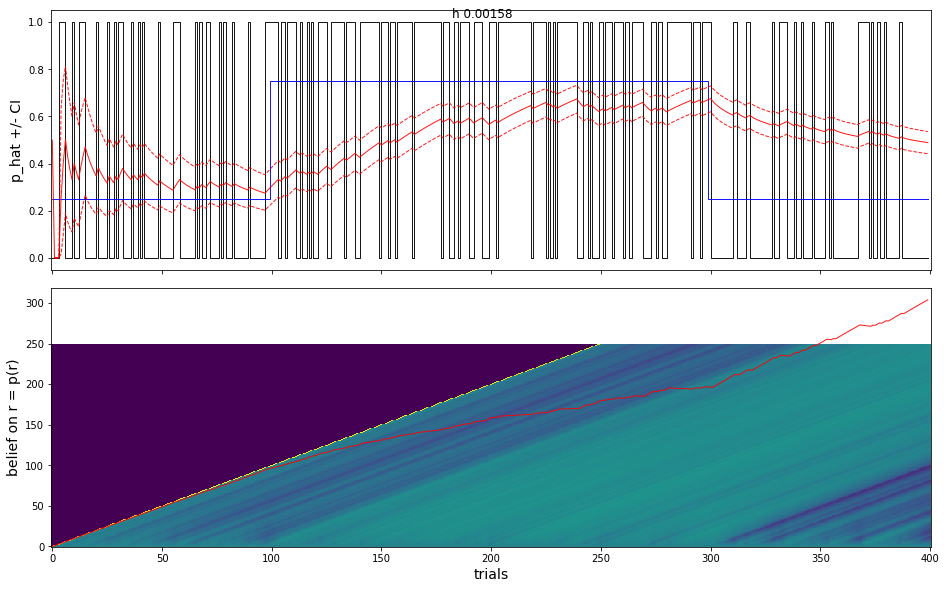

time 0 ; obs= 0 ; beliefs= [ 1.] ; p_hat= [ 0.5] ; 1-h= 0.997188293374 ; p_bar= [ 0.5]
Note that at t 0 , belief 0.00281170662595 = h =  0.00281170662595
time 1 ; obs= 0 ; beliefs= [ 0.00281171  0.99718829] ; p_hat= [ 0.5         0.42857143] ; 1-h= 0.997188293374 ; p_bar= [ 0.5  0. ]
Note that at t 1 , belief 0.00281170662595 = h =  0.00281170662595
time 2 ; obs= 0 ; beliefs= [ 0.00281171  0.00326957  0.99391872] ; p_hat= [ 0.5         0.42857143  0.4       ] ; 1-h= 0.997188293374 ; p_bar= [ 0.5  0.   0. ]
Note that at t 2 , belief 0.00281170662595 = h =  0.00281170662595
time 3 ; obs= 0 ; beliefs= [ 0.00281171  0.00350147  0.00348999  0.99019683] ; p_hat= [ 0.5         0.42857143  0.4         0.38461538] ; 1-h= 0.997188293374 ; p_bar= [ 0.5  0.   0.   0. ]
Note that at t 3 , belief 0.00281170662595 = h =  0.00281170662595
time 4 ; obs= 1 ; beliefs= [ 0.00281171  0.00363991  0.0038853   0.00361439  0.98604871] ; p_hat= [ 0.5         0.57142857  0.6         0.61538462  0.625     ] ; 1-h

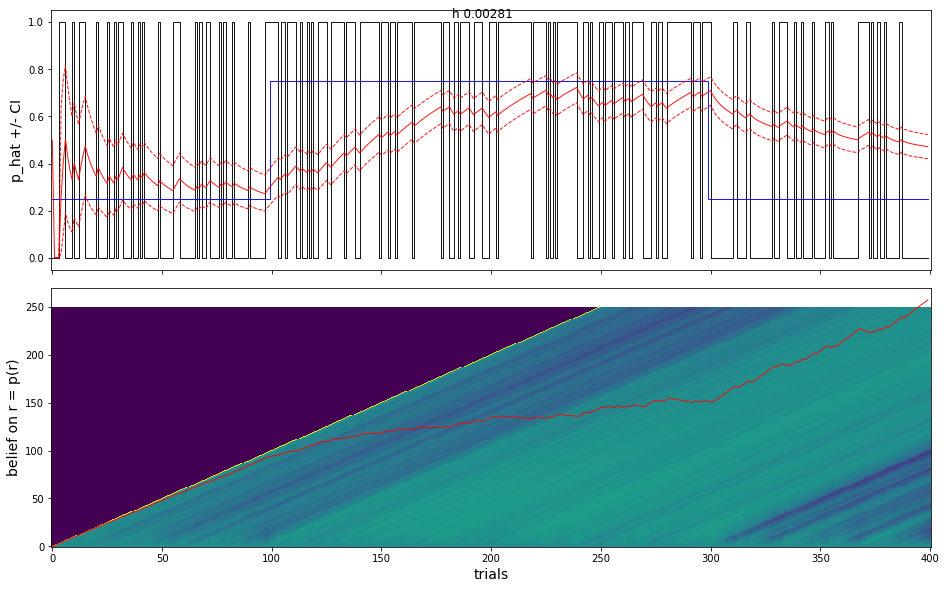

time 0 ; obs= 0 ; beliefs= [ 1.] ; p_hat= [ 0.5] ; 1-h= 0.995 ; p_bar= [ 0.5]
Note that at t 0 , belief 0.005 = h =  0.005
time 1 ; obs= 0 ; beliefs= [ 0.005  0.995] ; p_hat= [ 0.5         0.42857143] ; 1-h= 0.995 ; p_bar= [ 0.5  0. ]
Note that at t 1 , belief 0.005 = h =  0.005
time 2 ; obs= 0 ; beliefs= [ 0.005       0.00579933  0.98920067] ; p_hat= [ 0.5         0.42857143  0.4       ] ; 1-h= 0.995 ; p_bar= [ 0.5  0.   0. ]
Note that at t 2 , belief 0.005 = h =  0.005
time 3 ; obs= 0 ; beliefs= [ 0.005       0.00620842  0.00617223  0.98261935] ; p_hat= [ 0.5         0.42857143  0.4         0.38461538] ; 1-h= 0.995 ; p_bar= [ 0.5  0.   0.   0. ]
Note that at t 3 , belief 0.005 = h =  0.005
time 4 ; obs= 1 ; beliefs= [ 0.005       0.00645165  0.00686649  0.00637137  0.97531048] ; p_hat= [ 0.5         0.57142857  0.6         0.61538462  0.625     ] ; 1-h= 0.995 ; p_bar= [ 0.5  0.   0.   0.   0. ]
Note that at t 4 , belief 0.005 = h =  0.005
time 5 ; obs= 1 ; beliefs= [ 0.005       0.00

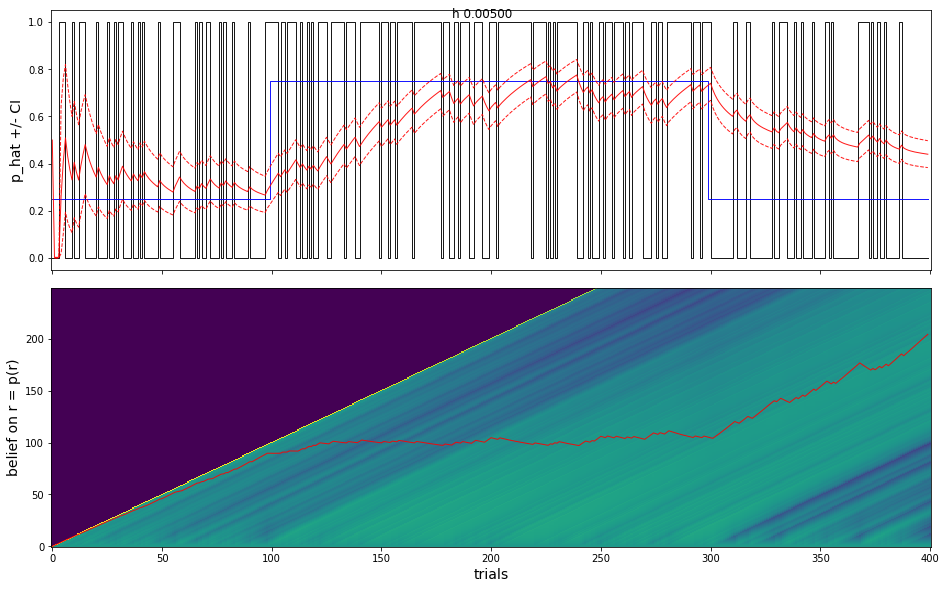

time 0 ; obs= 0 ; beliefs= [ 1.] ; p_hat= [ 0.5] ; 1-h= 0.99110860295 ; p_bar= [ 0.5]
Note that at t 0 , belief 0.00889139705019 = h =  0.00889139705019
time 1 ; obs= 0 ; beliefs= [ 0.0088914  0.9911086] ; p_hat= [ 0.5         0.42857143] ; 1-h= 0.99110860295 ; p_bar= [ 0.5  0. ]
Note that at t 1 , belief 0.00889139705019 = h =  0.00889139705019
time 2 ; obs= 0 ; beliefs= [ 0.0088914   0.01026585  0.98084275] ; p_hat= [ 0.5         0.42857143  0.4       ] ; 1-h= 0.99110860295 ; p_bar= [ 0.5  0.   0. ]
Note that at t 2 , belief 0.00889139705019 = h =  0.00889139705019
time 3 ; obs= 0 ; beliefs= [ 0.0088914   0.01098296  0.0108692   0.96925645] ; p_hat= [ 0.5         0.42857143  0.4         0.38461538] ; 1-h= 0.99110860295 ; p_bar= [ 0.5  0.   0.   0. ]
Note that at t 3 , belief 0.00889139705019 = h =  0.00889139705019
time 4 ; obs= 1 ; beliefs= [ 0.0088914   0.01140634  0.01207672  0.01115485  0.9564707 ] ; p_hat= [ 0.5         0.57142857  0.6         0.61538462  0.625     ] ; 1-h= 0.99

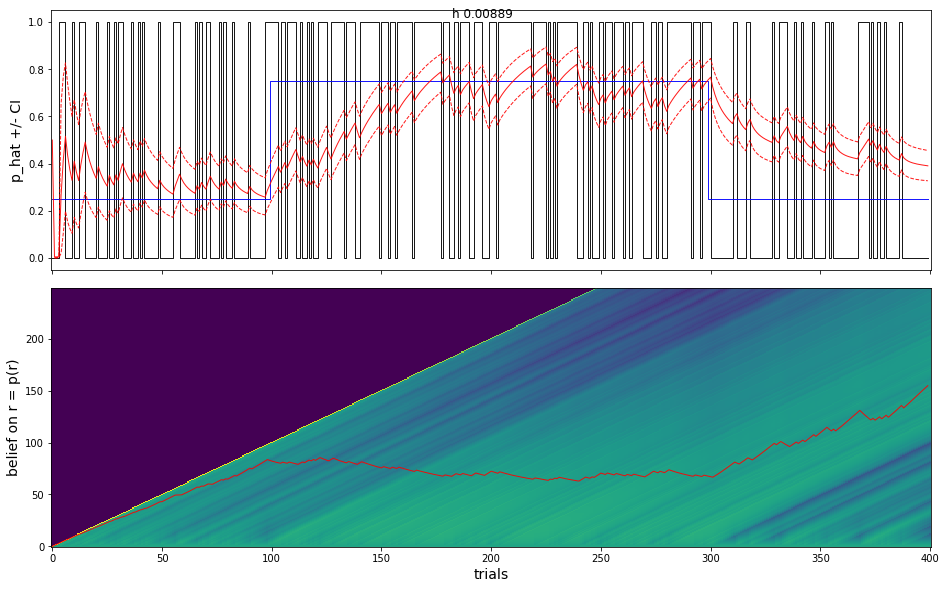

time 0 ; obs= 0 ; beliefs= [ 1.] ; p_hat= [ 0.5] ; 1-h= 0.984188611699 ; p_bar= [ 0.5]
Note that at t 0 , belief 0.0158113883008 = h =  0.0158113883008
time 1 ; obs= 0 ; beliefs= [ 0.01581139  0.98418861] ; p_hat= [ 0.5         0.42857143] ; 1-h= 0.984188611699 ; p_bar= [ 0.5  0. ]
Note that at t 1 , belief 0.0158113883008 = h =  0.0158113883008
time 2 ; obs= 0 ; beliefs= [ 0.01581139  0.01810724  0.96608138] ; p_hat= [ 0.5         0.42857143  0.4       ] ; 1-h= 0.984188611699 ; p_bar= [ 0.5  0.   0. ]
Note that at t 2 , belief 0.0158113883008 = h =  0.0158113883008
time 3 ; obs= 0 ; beliefs= [ 0.01581139  0.01935022  0.01899421  0.94584418] ; p_hat= [ 0.5         0.42857143  0.4         0.38461538] ; 1-h= 0.984188611699 ; p_bar= [ 0.5  0.   0.   0. ]
Note that at t 3 , belief 0.0158113883008 = h =  0.0158113883008
time 4 ; obs= 1 ; beliefs= [ 0.01581139  0.02007493  0.0210583   0.01929281  0.92376258] ; p_hat= [ 0.5         0.57142857  0.6         0.61538462  0.625     ] ; 1-h= 0.9841

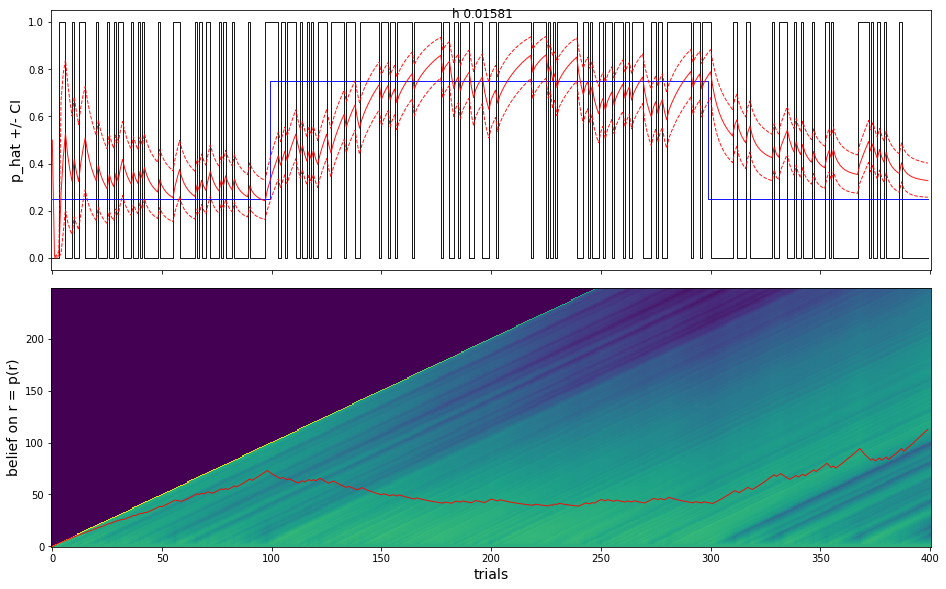

In [10]:
for h_ in 1/200*np.logspace(-.5, .5, 5):
    p_bar, r, beliefs = inference(o, h=h_, p0=.5)
    fig, axs = plot_inference(a, o, p_gen, p_bar, r, beliefs, max_run_length=250)
    fig.suptitle('h %.5f' % h_)
    plt.show()

## performing inference: application to experimental data

i_block= 0
time 0 ; obs= 0.0 ; beliefs= [ 1.] ; p_hat= [ 0.5] ; 1-h= 0.975 ; p_bar= [ 0.5]
Note that at t 0 , belief 0.025 = h =  0.025
time 1 ; obs= 1.0 ; beliefs= [ 0.025  0.975] ; p_hat= [ 0.5         0.57142857] ; 1-h= 0.975 ; p_bar= [ 0.5  0. ]
Note that at t 1 , belief 0.025 = h =  0.025
time 2 ; obs= 1.0 ; beliefs= [ 0.025       0.02139498  0.95360502] ; p_hat= [ 0.5         0.57142857  0.57692308] ; 1-h= 0.975 ; p_bar= [ 0.5  1.   0.5]
Note that at t 2 , belief 0.025 = h =  0.025
time 3 ; obs= 0.0 ; beliefs= [ 0.025       0.02119999  0.02073478  0.93306523] ; p_hat= [ 0.5         0.42857143  0.4375      0.43661972] ; 1-h= 0.975 ; p_bar= [ 0.5         1.          1.          0.66666667]
Note that at t 3 , belief 0.025 = h =  0.025
time 4 ; obs= 1.0 ; beliefs= [ 0.025       0.02782205  0.02022264  0.02019094  0.90676436] ; p_hat= [ 0.5         0.57142857  0.57692308  0.56338028  0.56451613] ; 1-h= 0.975 ; p_bar= [ 0.5         0.          0.5         0.66666667  0.5       ]
Note t

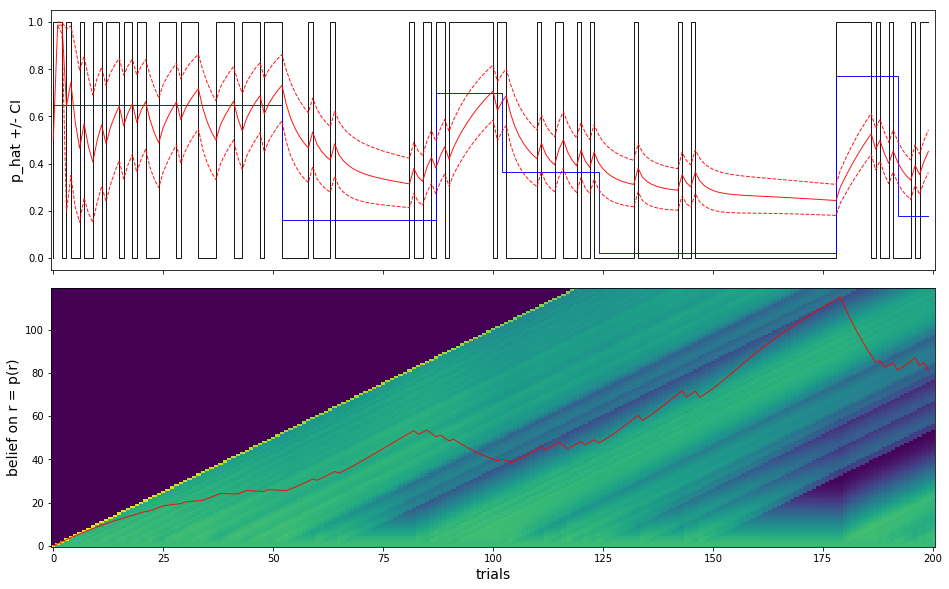

i_block= 1
time 0 ; obs= 1.0 ; beliefs= [ 1.] ; p_hat= [ 0.5] ; 1-h= 0.975 ; p_bar= [ 0.5]
Note that at t 0 , belief 0.025 = h =  0.025
time 1 ; obs= 0.0 ; beliefs= [ 0.025  0.975] ; p_hat= [ 0.5         0.42857143] ; 1-h= 0.975 ; p_bar= [ 0.5  1. ]
Note that at t 1 , belief 0.025 = h =  0.025
time 2 ; obs= 1.0 ; beliefs= [ 0.025      0.0283195  0.9466805] ; p_hat= [ 0.5         0.57142857  0.57692308] ; 1-h= 0.975 ; p_bar= [ 0.5  0.   0.5]
Note that at t 2 , belief 0.025 = h =  0.025
time 3 ; obs= 1.0 ; beliefs= [ 0.025       0.02120139  0.02744744  0.92635117] ; p_hat= [ 0.5         0.57142857  0.57692308  0.56338028] ; 1-h= 0.975 ; p_bar= [ 0.5         1.          0.5         0.66666667]
Note that at t 3 , belief 0.025 = h =  0.025
time 4 ; obs= 0.0 ; beliefs= [ 0.025       0.0216729   0.02100552  0.02745534  0.90486624] ; p_hat= [ 0.5         0.42857143  0.4375      0.43661972  0.44805195] ; 1-h= 0.975 ; p_bar= [ 0.5         1.          1.          0.66666667  0.75      ]
Note that

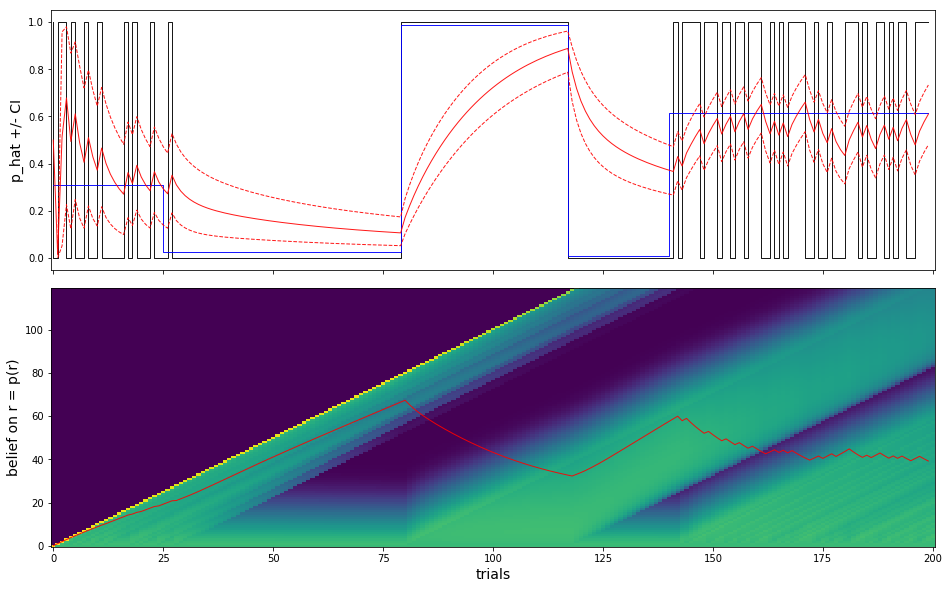

i_block= 2
time 0 ; obs= 1.0 ; beliefs= [ 1.] ; p_hat= [ 0.5] ; 1-h= 0.975 ; p_bar= [ 0.5]
Note that at t 0 , belief 0.025 = h =  0.025
time 1 ; obs= 0.0 ; beliefs= [ 0.025  0.975] ; p_hat= [ 0.5         0.42857143] ; 1-h= 0.975 ; p_bar= [ 0.5  1. ]
Note that at t 1 , belief 0.025 = h =  0.025
time 2 ; obs= 0.0 ; beliefs= [ 0.025      0.0283195  0.9466805] ; p_hat= [ 0.5         0.42857143  0.42307692] ; 1-h= 0.975 ; p_bar= [ 0.5  0.   0.5]
Note that at t 2 , belief 0.025 = h =  0.025
time 3 ; obs= 0.0 ; beliefs= [ 0.025       0.02866598  0.02783335  0.91850067] ; p_hat= [ 0.5         0.42857143  0.4         0.41818182] ; 1-h= 0.975 ; p_bar= [ 0.5         0.          0.          0.33333333]
Note that at t 3 , belief 0.025 = h =  0.025
time 4 ; obs= 0.0 ; beliefs= [ 0.025       0.02901654  0.02851843  0.02584409  0.89162095] ; p_hat= [ 0.5         0.42857143  0.4         0.38461538  0.41489362] ; 1-h= 0.975 ; p_bar= [ 0.5   0.    0.    0.    0.25]
Note that at t 4 , belief 0.025 = h =  

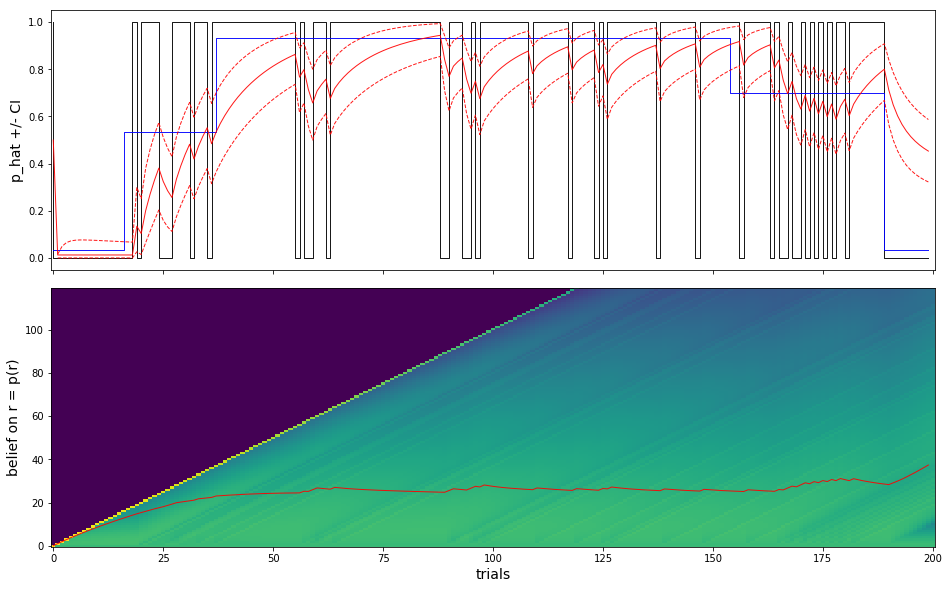

In [11]:
for i_block in range(3):
    print('i_block=', i_block)
    o = p[:, i_block, 0]
    p_bar, r, beliefs = inference(o, h=h, p0=.5)
    fig, axs = plot_inference(a, p[:, i_block, 0], p[:, i_block, 1], p_bar, r, beliefs)
    plt.show()